# **Binary Classification Model - Naive Bayes in Python**



## **Introduction**

In this course, we have used Bayesian methods to make binary predictions. This Python notebook is a demonstration of how these concepts might be used in ra real scenario.

**Scenario**
- We have a dataset of 5000 customers, who have been targetted in a marketing campaign to sign up for a personal loan.
- We've been getting complaints from uninterested customers that we are sending out too many emails,  
- For each customer we have information about demographics, loan history, relationships, and whether they signed up for a personal loan.
- We know that in total, 9.2% of customers typically sign up for a personal loan. We can think of this as our Prior Probability.

**Objectives**
- To reduce unwanted emails, can we predict which customers WILL sign up for personal loans, given the information we know about them.
- For example: for a given level of income, a given zip code, and a given age, what is the customer likely to SIGN UP for a personal loan, or NOT.

**Priorities**
- In the past the company emailed ALL customers. For future customers, we want our email campaign to be more targetted.
- As a starting point, this new email campaign must maximise the identification of customers who are likely to sign up for a loan, even if it means emailing a few that will not sign up. This will still be far more effective than our current solution.



## **Import Python Packages**



In this section we will import all the Python functionality we need to create and run our model.

In [1]:
# Importing the pacakges we'll use to 
import pandas as pd                       #Pandas is used for data manipulation and allows us to view tables of data
import matplotlib.pyplot as plt           #Matplotlib is used to create charts and plots
import sklearn as sk                      #SKLearn is a collection of simple and efficient tools for predictive data analysis

# Additionally, we need to import a few specific subpackages of SKLearn
import sklearn.model_selection as skms    
import sklearn.naive_bayes as nb
import sklearn.metrics as skm

## **Load Data**



In this section we will load the personal loans data from a CSV file located in the student files folder.

In [2]:
# Loading our csv into a dataframe
loan_df = pd.read_csv('Bank_Personal_Loan_Modelling.csv') # Data Source: https://www.kaggle.com/teertha/personal-loan-modeling
#By defining only a filename, the csv file is assumed to be in the same location as this Python notebook

# Check what the imported data looks like
loan_df.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


Personal Loan is our target column, where 1 represents DID sign up, and 0 represents DID NOT sign up.

Overall, 9.2% of observations signed up for a personal loan.

## **Exploratory Data Analysis**

Exploratory Data Analysis is about investigating data at a basic level to try and identify any obvious patterns or relationships.

In this section we will look at which variables are likely to be good influencers of Personal Loan Acceptance.

**Check how much data we are working with**


In [3]:
# Use the shape function to describe the number of rows and columns in the dataframe.
loan_df.shape

(5000, 14)

**Plot correlation matrix to identify any obvious patterns in the data.**


In [4]:
# Correlation plot - to see which variables tend to move with each other (e.g. age tends to go with experience)
loan_df.corr().style.background_gradient(cmap='coolwarm').set_precision(4)

C:\Users\Thanh Le\AppData\Local\Temp\ipykernel_3764\3813212091.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  loan_df.corr().style.background_gradient(cmap='coolwarm').set_precision(4)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
ID,1.0000,-0.0085,-0.0083,-0.0177,0.0134,-0.0168,-0.0247,0.0215,-0.0139,-0.0248,-0.0170,-0.0069,-0.0025,0.0170
Age,-0.0085,1.0000,0.9942,-0.0553,-0.0292,-0.0464,-0.0520,0.0413,-0.0125,-0.0077,-0.0004,0.0080,0.0137,0.0077
Experience,-0.0083,0.9942,1.0000,-0.0466,-0.0286,-0.0526,-0.0501,0.0132,-0.0106,-0.0074,-0.0012,0.0104,0.0139,0.0090
Income,-0.0177,-0.0553,-0.0466,1.0000,-0.0164,-0.1575,0.6460,-0.1875,0.2068,0.5025,-0.0026,0.1697,0.0142,-0.0024
ZIP Code,0.0134,-0.0292,-0.0286,-0.0164,1.0000,0.0118,-0.0041,-0.0174,0.0074,0.0001,0.0047,0.0200,0.0170,0.0077
Family,-0.0168,-0.0464,-0.0526,-0.1575,0.0118,1.0000,-0.1093,0.0649,-0.0204,0.0614,0.0200,0.0141,0.0104,0.0116
CCAvg,-0.0247,-0.0520,-0.0501,0.6460,-0.0041,-0.1093,1.0000,-0.1361,0.1099,0.3669,0.0151,0.1365,-0.0036,-0.0067
Education,0.0215,0.0413,0.0132,-0.1875,-0.0174,0.0649,-0.1361,1.0000,-0.0333,0.1367,-0.0108,0.0139,-0.0150,-0.0110
Mortgage,-0.0139,-0.0125,-0.0106,0.2068,0.0074,-0.0204,0.1099,-0.0333,1.0000,0.1421,-0.0054,0.0893,-0.0060,-0.0072
Personal Loan,-0.0248,-0.0077,-0.0074,0.5025,0.0001,0.0614,0.3669,0.1367,0.1421,1.0000,0.0220,0.3164,0.0063,0.0028


All the red cells in the correlation matrix show the highest correlation.
- Experience appears to be highly correlated with age, which is expected.
- Personal Loan is our targrte variable, so the Personal Loan row is particularly interested.
- Personal Loan appears to be somewhat correlated with Income and CCAvg (Credit Card Avg Balance)

## **Feature Engineering**



Feature engineering is about modifying the data to make it more usuable for our analysis.

In this case, we know that our models only work well with positive values. For this reason, we will use some simple summary statistics to check if any columns contain negative values. If they do, we'll fix them where appropriate.

**Investigate negative values in the dataset**


In [5]:
#Display summary statistics of each column, to help us investigate the minimum values in each column
loan_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


The summary statistics show that negative values exist in the Experience column. This is not possible, and is an example of dirty data.

To fix this problem, we will convert any values less than zero into 0.

**Convert all negative values into zeros**



In [6]:
# Convert all values less than 0 to 0
loan_df[loan_df < 0] = 0

#Display NEW summary statistics of each column in the dataframe
loan_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.119600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.440484,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,0.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


The summary statistics now show that the minimum value in the Experience Column is 0, as we would expect.

**Remove any useless columns**

We can also remove the ID column from the dataset since it simply identifies the row number and has no predictive power.

In [7]:
# Remove (drop) the ID column as it has no predictive power.
loan_df = loan_df.drop('ID', axis=1)
loan_df.head(10)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
5,37,13,29,92121,4,0.4,2,155,0,0,0,1,0
6,53,27,72,91711,2,1.5,2,0,0,0,0,1,0
7,50,24,22,93943,1,0.3,3,0,0,0,0,0,1
8,35,10,81,90089,3,0.6,2,104,0,0,0,1,0
9,34,9,180,93023,1,8.9,3,0,1,0,0,0,0


## **Train, Test Split**



In this section we will split the data set of personal loans into training data, and test data.

In [10]:
# Create a dataframe called X, which contains the explanatory variables
X = loan_df.drop(columns=['Personal Loan'])

# Create a dataframe called Y, which contains only the target variable, Personal Loan
y = loan_df['Personal Loan']

In [11]:
# Use the Train test split function to split both X and Y into separate training and test data.
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2)

We will use a test size of 0.2 which means we save 20% of our data for testing.

## **Model 1 - Multinomial Naive Bayes Classification**



In this section we will use the Multinomial Naive Bayes classification model to predict which customers wil sign up for a personal loan.

The model does all the hard work for us, from calculating Priors, distributions, and scores.

Link to model documentation: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

**Setup and train the model**

In [12]:
# Setting up Multinoimal Naive Bayes Classification Model
MNB = nb.MultinomialNB()

# Fit the model to the training data
MNB.fit(X_train, y_train)

MultinomialNB()

In [13]:
# MNB has a log value of priors made from the data.  Have to do some math to get percents
# first group is the no signups (0), while second is sign ups (1)
import numpy as np
np.exp(MNB.class_log_prior_)

array([0.9025, 0.0975])

**Create predictions using the trained model**

Here we will make a prediction for each loan in the test data, and compare that prediction to the actual value.



In [14]:
# Creating predictions
predictions = MNB.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).tail(10)

,Prediction,Actual
308,0,0
4164,0,0
4293,1,0
2882,0,0
1559,1,1
4657,0,0
89,0,0
3658,0,0
2517,0,0
3127,0,0


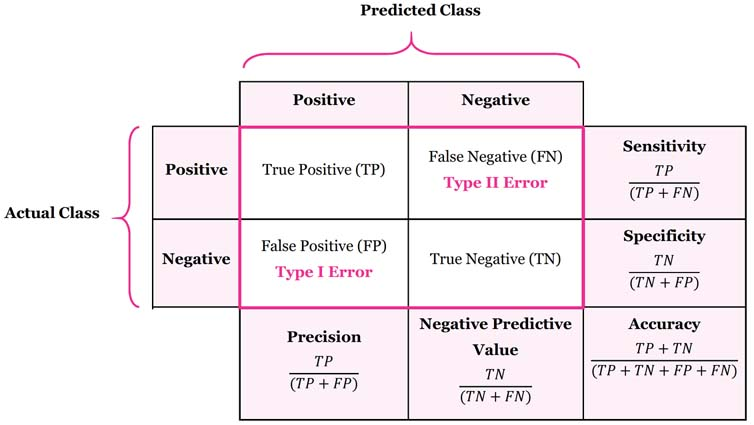

**Model Evaluation**

Here we can summarize the results of all our predictions into a few summary visuals and metrics

C:\Users\Thanh Le\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


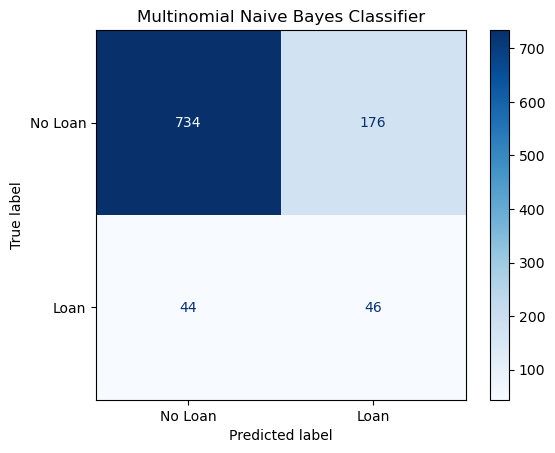

In [15]:
# Examining with confusion matrix (Think of getting values for Type I and Type II errors)
disp = skm.plot_confusion_matrix(MNB, X_test, y_test,
                              display_labels=['No Loan','Loan'],
                              cmap=plt.cm.Blues, values_format='d')
disp.ax_.set_title('Multinomial Naive Bayes Classifier');

The bottom-right and top-left quadrants of the confusion matrix show the **correct** predictions.

*   **The bottom-right shows True Positives**. Those we predicted would take a loan, that actually did.
*   **The top-left shows True Negatives**. Those we predicted would NOT take a loan, that did not take one.

The top-right and bottom-left of the confusion matrix show the **errors** in our predictions.

*   **The top-right shows False Positives**. Those we predicted would take a loan, that did not take one.
*   **The bottom-left shows False Negatives**. Those we predicted would NOT take a loan, that actually did.

Ideally, we want to make as many correct (TRUE) predictions as possible. However, since no model is perfect, we always have to deal with some level of FALSE predictions.

Here are some basic evaluation metrics that we can use to evalute the errors in our predictions.

In [23]:
# Accuracy: Overall, what proportion of predictions were correct?
model1_accuracy = skm.accuracy_score(y_test,predictions)
print("Accuracy: ", model1_accuracy)

Accuracy:  0.78


In [24]:
# Precision: Measures the quality of Positive Predictions. Out of those predicted positive (loan), how many actually were?
model1_precision = skm.precision_score(y_test, predictions)
print("Precision: ", model1_precision)

Precision:  0.2072072072072072


In [25]:
# Recall: Measures the proportion of positive cases (Loan) that were correctly identified.
model1_recall = skm.recall_score(y_test, predictions)
print("Recall: ", model1_recall)

Recall:  0.5111111111111111


In [26]:
# F1 is effectively an average between precision and recall. The higher the better.
model1_f1 = skm.f1_score(y_test, predictions)
print("F1 Score: ", model1_f1)

F1 Score:  0.2948717948717949


## **Model 2 - Gaussian Naive Bayes Classification**

In this section we will use the Gaussian Naive Bayes classification model to predict which customers wil sign up for a personal loan.

Again, the model does all the hard work for us, from calculating Priors to calculating likelihood scores.

Link to model documentation: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html






**Plotting an example variable (Income)**

For each variable we can see the distribution for Loan Taken, vs Loan Not Taken

Personal Loan
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: Income, dtype: object

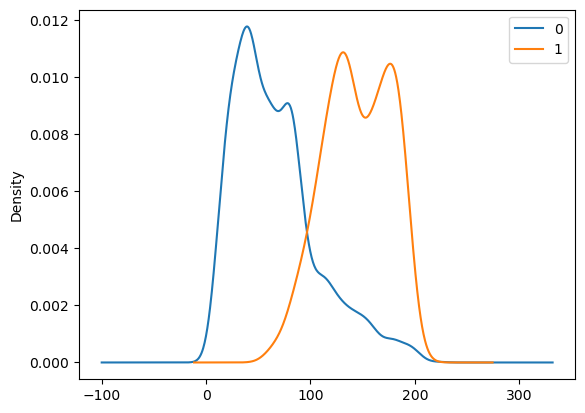

In [27]:
# Distributions of Loans taken and Loans not taken, by income.
loan_df[['Income','Personal Loan']].groupby('Personal Loan').Income.plot.kde(legend='Personal Loan')



****Setup and train the model using all the variables****

GNB runs through all the features and multiplies all the likelihoods taken from each distribution.

Using this we get an overall likelihood score for Loan, and a score for No Loan. The higher score of Loan or No Loan is taken as the result.

In [28]:
# Setting up Multinoimal Naive Bayes Classifier
GNB = nb.GaussianNB()
GNB.fit(X_train, y_train)

GaussianNB()

In [29]:
#Example of Gaussian priors after learning from the data
# first group is the no signups (0), while second is sign ups (1)
GNB.class_prior_

array([0.9025, 0.0975])

**Create predictions using the trained model**

Here we will make a prediction for each loan in the test data, and compare that prediction to the actual value.

In [30]:
# Creating predictions
gaussian_predictions = GNB.predict(X_test)
pd.DataFrame({"Prediction": gaussian_predictions, "Actual": y_test}).tail(10)

,Prediction,Actual
308,1,0
4164,0,0
4293,0,0
2882,0,0
1559,0,1
4657,0,0
89,0,0
3658,0,0
2517,0,0
3127,0,0


**Model Evaluation**

Here we can summarize the results of all our predictions into a few summary visuals and metrics

C:\Users\Thanh Le\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Gaussian Naive Bayes Classifier')

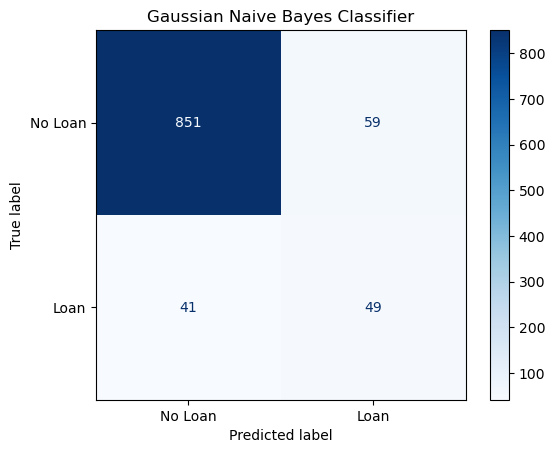

In [31]:
# Examining with confusion matrix (Think of getting values for Type I and Type II errors)
disp = skm.plot_confusion_matrix(GNB, X_test, y_test,
                              display_labels=['No Loan','Loan'],
                              cmap=plt.cm.Blues, values_format='d')
disp.ax_.set_title('Gaussian Naive Bayes Classifier')

In [32]:
# Accuracy: Overall, what proportion of predictions were correct?
model2_accuracy = skm.accuracy_score(y_test,gaussian_predictions)
print("Accuracy: ", model2_accuracy)

Accuracy:  0.9


In [33]:
# Precision: Measures the quality of Positive Predictions. Out of those predicted positive (loan),how many actually were?
model2_precision = skm.precision_score(y_test, gaussian_predictions)
print("Precision: ", model2_precision)

Precision:  0.4537037037037037


In [34]:
# Recall: Measures the proportion of positive cases (Loan) that were correctly identified.
model2_recall = skm.recall_score(y_test, gaussian_predictions)
print("Recall: ", model2_recall)

Recall:  0.5444444444444444


In [35]:
# F1 is effectively an average between precision and recall. The higher the better.
model2_f1 = skm.f1_score(y_test, gaussian_predictions)
print("F1 Score: ", model2_f1)

F1 Score:  0.494949494949495


## **Comparing Results**



In this section we will look at the results of the two models side by side.

In [36]:
# Model 1 - Multinomial Naive Bayes
print("Model 1 - Multinomial Naive Bayes")
print("Accuracy: ", model1_accuracy)
print("Precision: ", model1_precision)
print("Recall: ", model1_recall)
print("F1 Score: ", model1_f1)
print("\n") #Line break

# Model 2 - Gaussian Naive Bayes
print("Model 2 - Gaussian Naive Bayes")
print("Accuracy: ", model2_accuracy)
print("Precision: ", model2_precision)
print("Recall: ", model2_recall)
print("F1 Score: ", model2_f1)

Model 1 - Multinomial Naive Bayes
Accuracy:  0.78
Precision:  0.2072072072072072
Recall:  0.5111111111111111
F1 Score:  0.2948717948717949


Model 2 - Gaussian Naive Bayes
Accuracy:  0.9
Precision:  0.4537037037037037
Recall:  0.5444444444444444
F1 Score:  0.494949494949495


**Reminder of Priorities**

"This new email campaign must maximise the identification of customers who are likely to sign up for a loan, even if it means emailing a few that will not sign up."

**Recall** describes the proportion of actual postives were correctly identified. Therefore we are particularly interested in maximising Recall in order to capture all the probable loan sign ups.

Based on this and the fact that the Gaussian model outperforms the Multinomial on all metrics, **we can say that the Gaussian model has more predictive power**.

## **Conclusion**

The Gaussian model seems to have more predictive power, atleast at a glance. We can use this as a starting point to further refine our model, and implement a more targetted email campaign, targetting customers that are most likely to sign up for a personal loan.

In [38]:
2/51 * 9/51 / 2/17 * 100

0.020354162426216158